<a href="https://colab.research.google.com/github/Masoomas98/DSPS_MSarfraz/blob/main/lab/Lab_12_8_DSPS2023_autoencoders_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from copy import deepcopy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from scipy.signal import convolve2d

from tensorflow import keras
from keras.datasets import mnist
from keras import layers

!pip install icecream
from icecream import ic

rng = np.random.RandomState(1415)

# Load MNIST data

In [42]:
# Load the data and split it between train and test sets
(Xtrn, Ytrn), (Xtst, Ytst) = mnist.load_data()

# Visualize dataset

In [43]:
Xtrn.shape, Xtst.shape, Ytrn.shape ,Ytst.shape


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [44]:
np.unique(Ytrn)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [45]:
def plot_images(images, labels, nrows=5, ncols=5, vmin = 0, vmax=255):
  fig, axes = plt.subplots(nrows, ncols, sharex = True, sharey=True, figsize=(8,8))
  for i in range(nrows * ncols):
    ax = axes.flatten()[i]
    image = images[i]
    label = labels[i]
    ax.set_title(label)
    ax.imshow(image, vmin = vmin, vmax= vmax, cmap = "Greys")
    ax.set_aspect("equal")
    ax.axis("off")
  fig.tight_layout()
  fig.show()


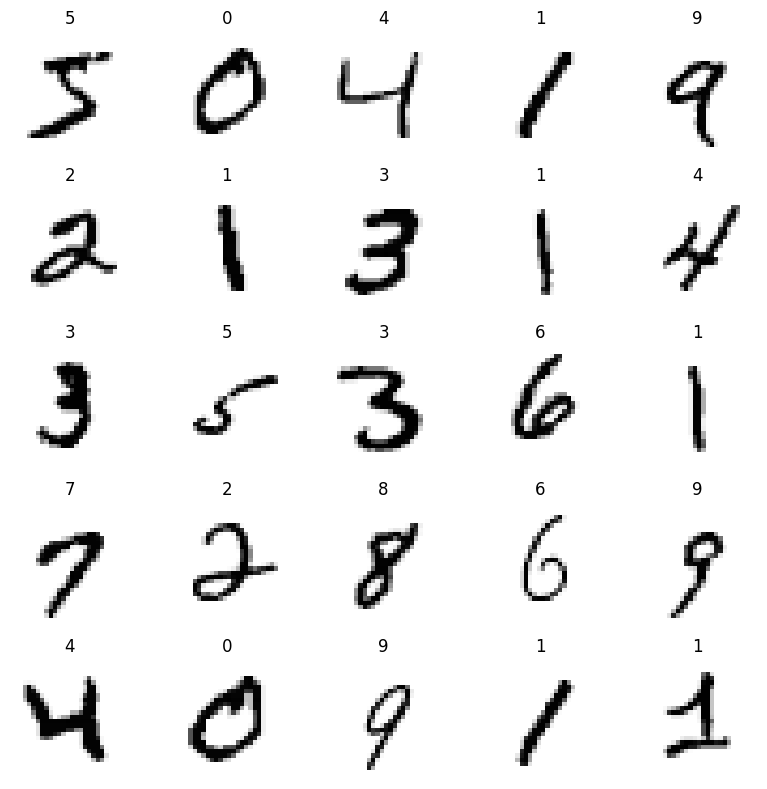

In [46]:
plot_images(Xtrn, Ytrn)

# Normalize the images

In [61]:
def normalize_255(array):
  normal_array = array/255
  return normal_array
XtrnN = normalize_255(Xtrn)
XtstN = normalize_255(Xtst)
XtrnN.min(), XtrnN.max()

(0.0, 1.0)

# Reshape the arrays for Keras

In [64]:
def reshape(array):
  reshaped_array = array[..., None]
  return reshaped_array
XtrnNR = reshape(XtrnN)
YtrnNR= reshape(Ytrn)
XtrnNR.shape,YtrnNR.shape


((60000, 28, 28, 1), (60000, 1))

# One-hot encode the image labels

YtrnOH = keras.utils.to_categorical(Ytrn,10)
we dont want to know what these pictures are.

# But wait we don't need the image labels...

### The training set will be the images at half resolution, and the model will try to up-sample the images to the original resolution... `Xtrn` should be the same 60,000 images at half resolution, but `Ytrn` should be those same images at the original resolution. We will do the same operations for the testing set.

# Construct dataset for superresolution, not image classification

In [65]:
def superresolution(X):
  Xnew = deepcopy(X)[:, ::2, ::2, :] # 1 dimension all images, 2 dimensions height and width, last dimension
  Ynew = deepcopy(X)
  return Xnew, Ynew
XtrnSR ,  YtrnSR = superresolution(XtrnNR)
XtstSR ,  YtstSR = superresolution(XtrnNR)
XtrnSR.shape,  YtrnSR.shape,

((60000, 14, 14, 1), (60000, 28, 28, 1))

# Visualize the new dataset

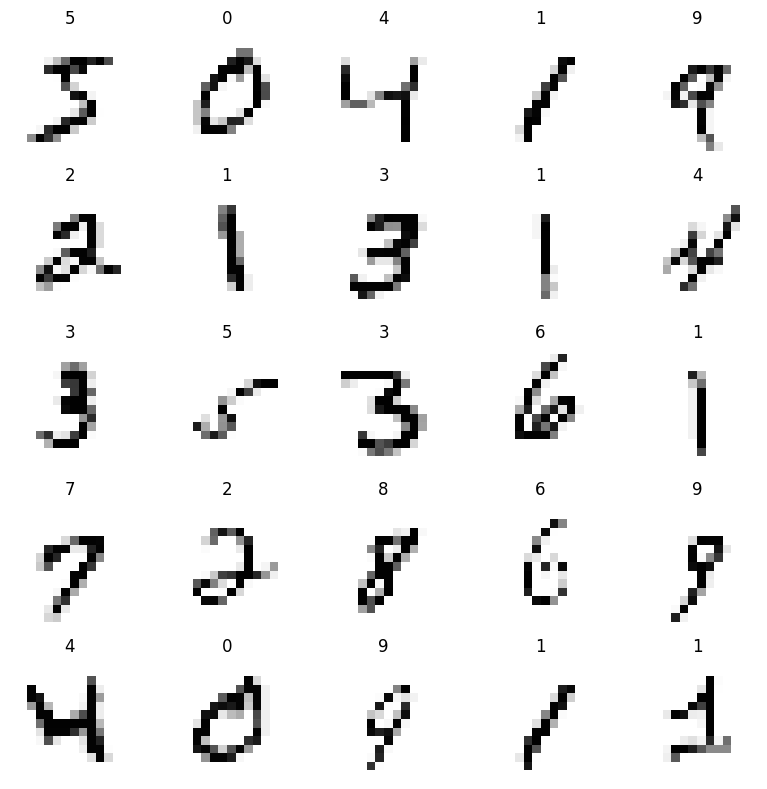

In [66]:
plot_images(XtrnSR[:, :, :, 0], Ytrn, vmax=1)

# Build the CNN autoencoder

In [67]:
def build_cnn(input_shape):
  inputs = layers.Input(shape = input_shape)

  #The encoder
  x = layers.Conv2D(16, kernel_size =(3,3), padding="same", activation = "relu")(inputs)
  x = layers.Conv2D(8, kernel_size =(3,3), padding="same", activation = "relu")(x)
  x = layers.Conv2D(4, kernel_size =(3,3), padding="same", activation = "relu")(x)
  x = layers.MaxPooling2D(pool_size = (2,2))(x)
  shape = x.shape
  num_neurons = shape[1] * shape[2]* shape[3]

  #The latent size
  x = layers.Flatten()(x)
  LS = layers.Dense(16, activation="relu")(x)
  x = layers.Dense(num_neurons, activation="relu")(LS)
  x = layers.Reshape(shape[1:])(x)

  #The decoder
  x = layers.Convolution2DTranspose(4, kernel_size = (3,3), padding="same", activation = "relu")(x)
  x = layers.Convolution2DTranspose(8, kernel_size = (3,3), padding="same", activation = "relu")(x)
  x = layers.Convolution2DTranspose(16, kernel_size = (3,3), padding="same", activation = "relu")(x)
  x = layers.UpSampling2D(size = (2,2))(x)

  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding= "same", activation="relu")(x)
  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding= "same", activation="relu")(x)
  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding= "same", activation="relu")(x)
  x = layers.UpSampling2D(size = (2,2))(x)

  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding= "same", activation="sigmoid")(x)
  x = layers.Conv2DTranspose(16, kernel_size=(3,3), padding= "same", activation="sigmoid")(x)
  outputs = layers.Conv2DTranspose(1, kernel_size=(3,3), padding= "same", activation="sigmoid")(x)

  model = keras.Model(inputs, outputs)
  encoder = keras.Model(inputs, LS)
  decoder = keras.Model(LS, outputs)
  return model, encoder, decoder

In [68]:
input_shape= XtrnSR.shape[1:]
model, encoder, decoder = build_cnn(input_shape)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 4)         292       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 7, 7, 4)           0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 196)               0         
                                                           

# Train the model (use a GPU)

In [69]:
model.compile(loss = "mse", optimizer = "adam")
history = model.fit(XtrnSR, YtrnSR, batch_size=256, epochs = 15, validation_split= 0.1 )

Epoch 1/15
211/211 [==============================] - 7s 16ms/step - loss: 0.0810 - val_loss: 0.0541
Epoch 2/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0461 - val_loss: 0.0383
Epoch 3/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0341 - val_loss: 0.0299
Epoch 4/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0283 - val_loss: 0.0265
Epoch 5/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0258 - val_loss: 0.0245
Epoch 6/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0242 - val_loss: 0.0233
Epoch 7/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0232 - val_loss: 0.0231
Epoch 8/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0224 - val_loss: 0.0224
Epoch 9/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0219 - val_loss: 0.0217
Epoch 10/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0215 - val_lo

# Visualize loss curve

# Visualize the predictions

In [70]:
ptstSR =  model.predict(XtstSR)
ptstSR.shape

1875/1875 [==============================] - 5s 3ms/step


(60000, 28, 28, 1)

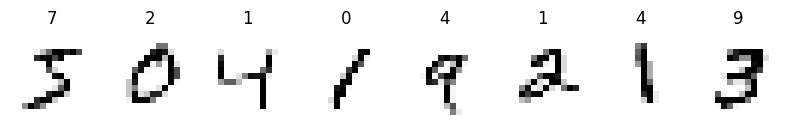

In [71]:
plot_images(XtstSR[...,0], Ytst, nrows=1, ncols=8, vmax=1)

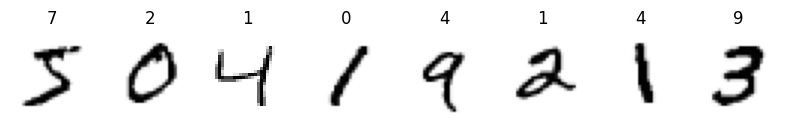

In [72]:
plot_images(YtstSR[...,0], Ytst, nrows=1, ncols=8, vmax=1)

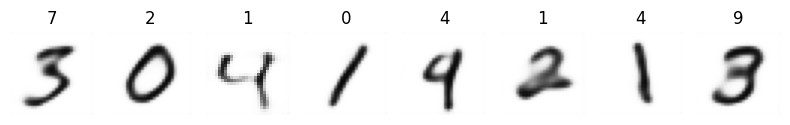

In [73]:
plot_images(ptstSR[...,0], Ytst, nrows=1, ncols=8, vmax=1)

# Visualize the early layers

In [74]:
model.layers[1].get_weights()[0].shape

(3, 3, 1, 16)

kernel_size = 3 * 3, and 16 filters

# Visualize the latent space with the encoder and decoder on their own

In [75]:
encoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 14, 4)         292       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 7, 7, 4)           0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 196)               0         
                                                           

In [76]:
decoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 16)]              0         
                                                                 
 dense_12 (Dense)            (None, 196)               3332      
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 4)           0         
                                                                 
 conv2d_transpose_36 (Conv2  (None, 7, 7, 4)           148       
 DTranspose)                                                     
                                                                 
 conv2d_transpose_37 (Conv2  (None, 7, 7, 8)           296       
 DTranspose)                                                     
                                                                 
 conv2d_transpose_38 (Conv2  (None, 7, 7, 16)          1168

# Find the average latent space representation for each digit

# Decode latent space representations with the decoder

# What if we input something in the latent space by hand and then decode it?